<img src="figures/oppdaterte-definisjoner.jpeg" alt="My Image" width="400" height="300">



In [373]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [385]:
### definerer geometrien til utkasteren
### Lengder er i meter, vekt i kg
AO = 0.125
CO = 0.378 # når EO=RO=C0 the ball is transitioning from the launcher to free fall
DO = 0.440

# AE is a spring
AE_L0 = 0.280 # resting lengt of the spring

DE = np.arange(0,11)*0.0235 + 0.039 # 11 settings from 0.039 to 0.274 speed setting
theta_deg_initial = [5.8, 9.7, 13.7, 17.7, 21.8, 26, 30.2] # height adjustment
theta_rad_initial = np.deg2rad(theta_deg_initial)
BO_initial = [0.123, 0.143, 0.163, 0.183, 0.203] # fine adjustment for height

power_setting = 10 # min 0, mid 5, max 10   #  10
heigt_main = 3    # up 0, mid 3, down 6    #  3
height_fine = 2    # down 0, mid 2, up 4    #  2
                                            # 25 m/s
#print(DE)

In [419]:
### baseball definition

r_ball = 0.074/2
m_ball = 0.145
r_ball_rolling = 0.030

I_ball = (2/5)*m_ball*r_ball**2

### launching arm definitions
m_AC = 7 # Guessing
AC = AO+CO
I_AC = (1/12)*m_AC*AC**2+m_AC*(AC/2-AO)**2 ### rod about centre + steiners thing

### spring
vindinger = 43
trådiameter = 4/1000
ytrediameter = 30.5/1000
nominelldiameter = ytrediameter-trådiameter
elastitesmodul = 210E9
v = 0.3
skjærmodul = elastitesmodul/(2*(1+v)) 
k = (skjærmodul*trådiameter**4)/(8*43*nominelldiameter**3)

In [421]:
def system(t, y):
    theta, theta_dot, r, r_dot = y

    spring_ekstension = np.sqrt((DE[power_setting] - AO * np.cos(theta))**2 + (-DO + AO * np.sin(theta))**2)-AE_L0
    phi = np.arctan2(-DO + AO * np.sin(theta), DE[power_setting] - AO * np.cos(theta))


    theta_ddot = (spring_ekstension*k*np.sin(theta-phi) - r * theta_dot * r_dot) / (I_AC + m_ball * r**2)

    rolling_ball_loss = (m_ball/(m_ball+I_ball/r_ball_rolling**2))
    #rolling_ball_loss = 1
    r_ddot = rolling_ball_loss*theta_dot**2*r
    
    return [theta_dot, theta_ddot, r_dot, r_ddot]


def event_ball_leaving_launcher(t, y):
    return y[2] - CO # y[2]=r CO is length of launcher arm

event_ball_leaving_launcher.terminal = True  # Stop integration when event is detected
event_ball_leaving_launcher.direction = 1    # Only trigger when r is increasing

# Define initial conditions: [theta, theta_dot, r, r_dot]
y0 = [theta_rad_initial[heigt_main], 0.0, BO_initial[height_fine], 0.0]  # Replace with your actual initial values

# Define the time span for the integration
t_span = (0, 0.5)  # Adjust the final time as needed
t_eval = np.linspace(t_span[0], t_span[1], 100000)
# Solve the ODE system with the event
sol = solve_ivp(system, t_span, y0, events=event_ball_leaving_launcher,t_eval=t_eval, dense_output=True)

In [423]:
theta, theta_dot, r, r_dot = sol.y

v_tangential = theta_dot*r
v_abs = np.sqrt(v_tangential**2+r_dot**2)
v_direction_on_AB = np.arctan2(v_tangential, r_dot)
v_direction_on_CD = v_direction_on_AB + theta

Fart 26.14 m/s med vinkel -11.7 grader.


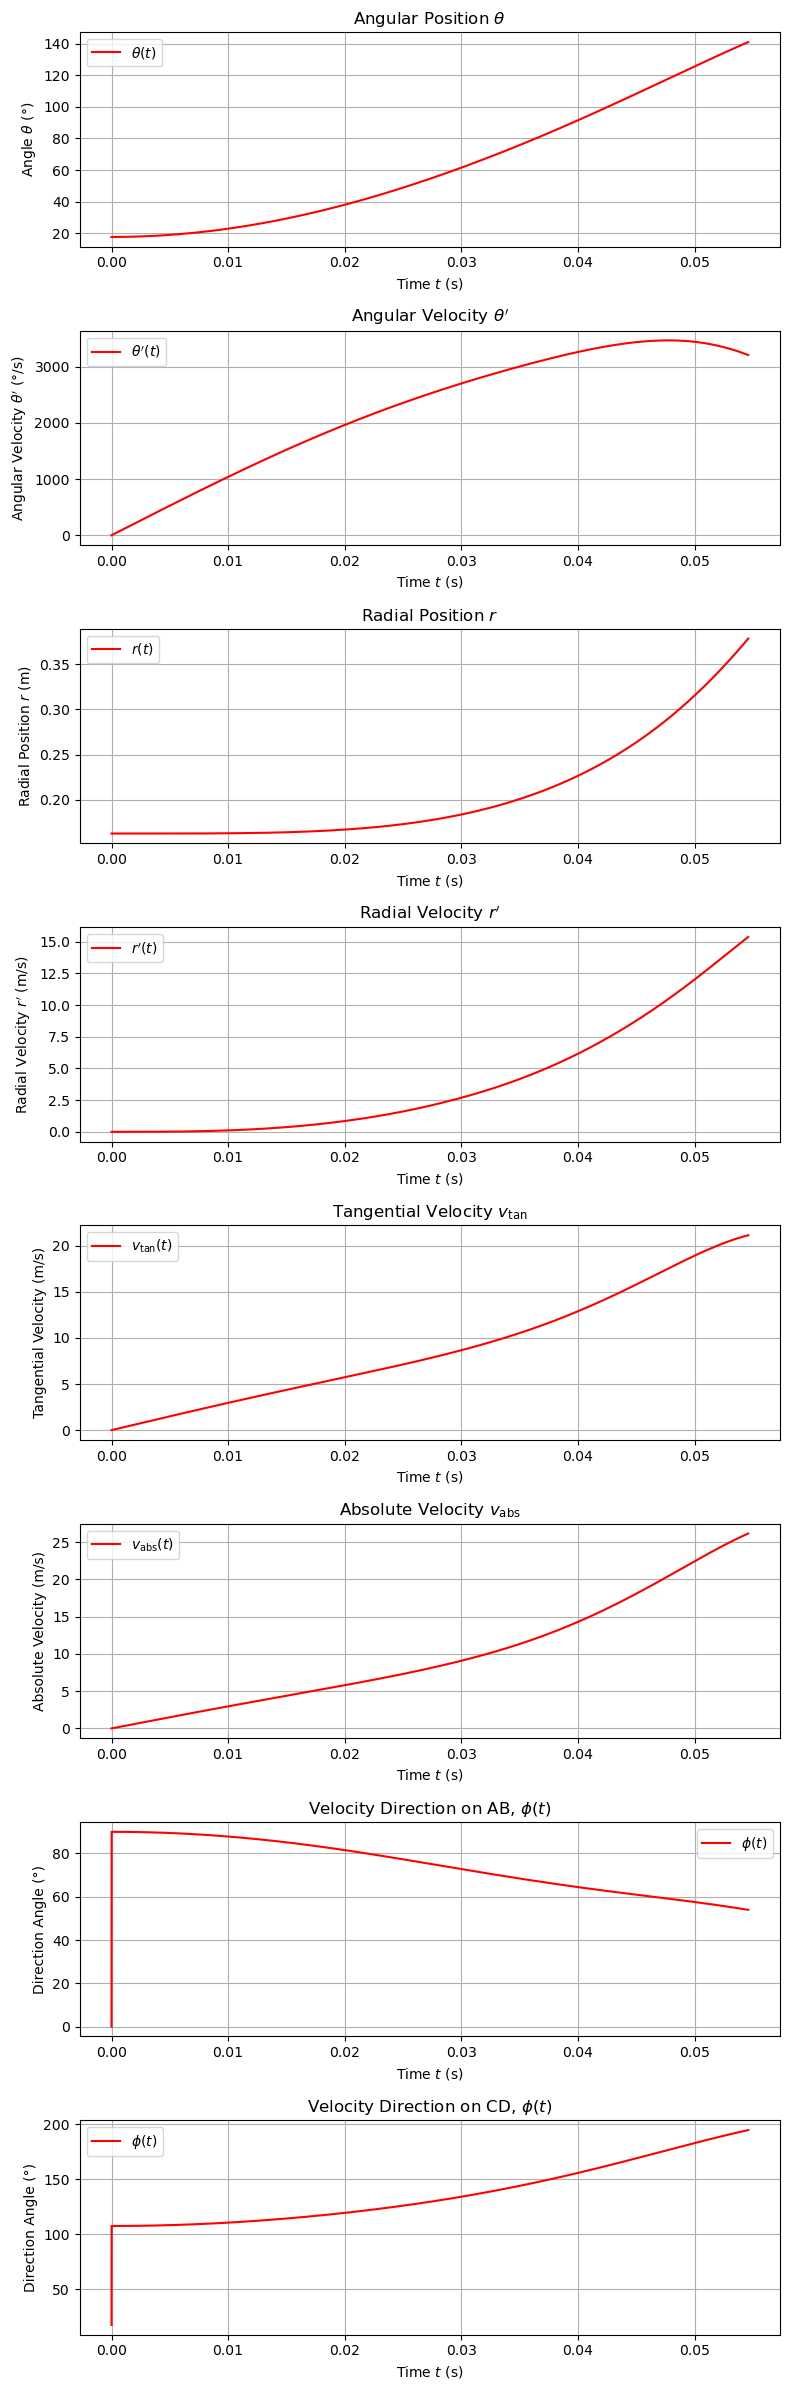

Fart 26.14 m/s med vinkel -11.7 grader.


In [425]:
print(f"Fart {v_abs[-1]:.2f} m/s med vinkel {np.rad2deg(np.pi -v_direction_on_CD[-1])+3.2:.1f} grader.")

fig, ax = plt.subplots(8, figsize=(8, 24))

# Plot θ (angular position)
ax[0].plot(sol.t, np.rad2deg(sol.y[0]), label=r"$\theta(t)$", color='red')
ax[0].set_xlabel(r"Time $t$ (s)")
ax[0].set_ylabel(r"Angle $\theta$ (°)")
ax[0].set_title(r"Angular Position $\theta$")
ax[0].legend()
ax[0].grid(True)

# Plot θ' (angular velocity)
ax[1].plot(sol.t, np.rad2deg(sol.y[1]), label=r"$\theta'(t)$", color='red')
ax[1].set_xlabel(r"Time $t$ (s)")
ax[1].set_ylabel(r"Angular Velocity $\theta'$ (°/s)")
ax[1].set_title(r"Angular Velocity $\theta'$")
ax[1].legend()
ax[1].grid(True)

# Plot r (radial position)
ax[2].plot(sol.t, sol.y[2], label=r"$r(t)$", color='red')
ax[2].set_xlabel(r"Time $t$ (s)")
ax[2].set_ylabel(r"Radial Position $r$ (m)")
ax[2].set_title(r"Radial Position $r$")
ax[2].legend()
ax[2].grid(True)

# Plot r' (radial velocity)
ax[3].plot(sol.t, sol.y[3], label=r"$r'(t)$", color='red')
ax[3].set_xlabel(r"Time $t$ (s)")
ax[3].set_ylabel(r"Radial Velocity $r'$ (m/s)")
ax[3].set_title(r"Radial Velocity $r'$")
ax[3].legend()
ax[3].grid(True)

# Plot tangential velocity: v_tangential = theta_dot * r
ax[4].plot(sol.t, v_tangential, label=r"$v_{\mathrm{tan}}(t)$", color='red')
ax[4].set_xlabel(r"Time $t$ (s)")
ax[4].set_ylabel(r"Tangential Velocity (m/s)")
ax[4].set_title(r"Tangential Velocity $v_{\mathrm{tan}}$")
ax[4].legend()
ax[4].grid(True)

# Plot absolute velocity: v_abs = sqrt(v_tan^2 + r_dot^2)
ax[5].plot(sol.t, v_abs, label=r"$v_{\mathrm{abs}}(t)$", color='red')
ax[5].set_xlabel(r"Time $t$ (s)")
ax[5].set_ylabel(r"Absolute Velocity (m/s)")
ax[5].set_title(r"Absolute Velocity $v_{\mathrm{abs}}$")
ax[5].legend()
ax[5].grid(True)

# Plot velocity direction on CD: v_direction_on_CD in degrees
ax[6].plot(sol.t, np.rad2deg(v_direction_on_AB), label=r"$\phi(t)$", color='red')
ax[6].set_xlabel(r"Time $t$ (s)")
ax[6].set_ylabel(r"Direction Angle (°)")
ax[6].set_title(r"Velocity Direction on AB, $\phi(t)$")
ax[6].legend()
ax[6].grid(True)

# Plot velocity direction on CD: v_direction_on_CD in degrees
ax[7].plot(sol.t, np.rad2deg(v_direction_on_CD), label=r"$\phi(t)$", color='red')
ax[7].set_xlabel(r"Time $t$ (s)")
ax[7].set_ylabel(r"Direction Angle (°)")
ax[7].set_title(r"Velocity Direction on CD, $\phi(t)$")
ax[7].legend()
ax[7].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
print(f"Fart {v_abs[-1]:.2f} m/s med vinkel {np.rad2deg(np.pi -v_direction_on_CD[-1])+3.2:.1f} grader.")

In [ ]:
spring_ekstension = np.sqrt((DE[power_setting] - AO * np.cos(theta))**2 + (-DO + AO * np.sin(theta))**2)
theta = np.linspace(0, 2*pi, 360)